In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.size'] = 13

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.backend as kb
import tensorflow.keras.losses

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import ops

from IPython.display import clear_output

In [2]:
def lorentzian(x, w=.5, c=0):
    return w**2 / (w**2 + (2*x - 2*c)**2)

def gaussian(x, w=.5, c=0):
    return np.exp(-(x - c)**2 / (2*w**2))

def generateBatchOneHot(batchsize, widthBounds=[.2, .8], centerBounds=[-.95, .95], xBounds=[-1, 1], xLength=30, numPeaks=1):
    lorentzians = np.zeros([batchsize, 1, xLength])
    
    widths = np.random.uniform(widthBounds[0], widthBounds[1], size=(batchsize, numPeaks))
    centers = np.random.uniform(centerBounds[0], centerBounds[1], size=(batchsize, numPeaks))
    
    xArr = np.linspace(xBounds[0], xBounds[1], xLength)
    
    for j in range(numPeaks):
        lorentzians[:,0,:] += np.array([lorentzian(xArr, w=widths[i,j], c=centers[i,j]) for i in range(batchsize)])
    
    # Now find the maxima
    maxima = np.zeros([batchsize, 1, xLength])
    #print(np.array((centers - xBounds[0])/((xBounds[1]-xBounds[0])/xLength), dtype=int))
    for i in range(batchsize):
        maxima[i,0,np.array((centers - xBounds[0])/((xBounds[1]-xBounds[0])/xLength), dtype=int)[i]] = 1
        lorentzians[i,0,:] /= np.max(lorentzians[i,0,:])
    #maxima[:,0,:] = np.array([[np.argmax(lorentzians[i,0,:]) == j for j in range(xLength)] for i in range(batchsize)])
    #maxima = np.array([np.argmax(lorentzians[i,0,:]) for i in range(batchsize)])
    return lorentzians, maxima

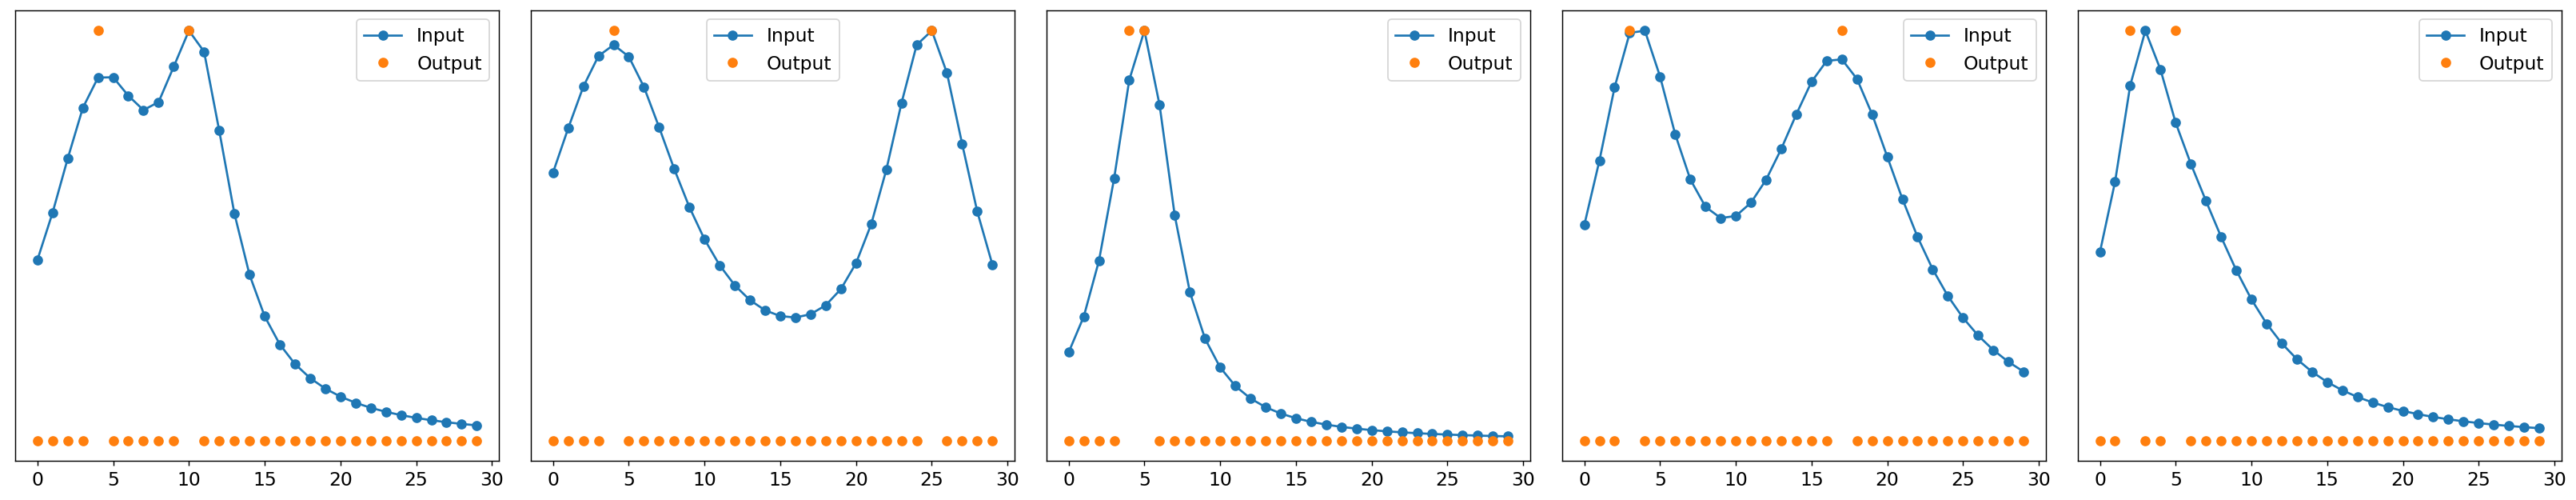

In [6]:
sampleSize = 30

inputs, outputs = generateBatchOneHot(5, numPeaks=2, xLength=sampleSize)

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    ax[i].plot(inputs[i,0,:], 'o-', label='Input')
    ax[i].plot(outputs[i,0,:], 'o', label='Output')
    ax[i].set_yticks([])
    ax[i].legend()
    
fig.tight_layout()
plt.show()

In [7]:
def linearWeight(sampleLength):
    wVec = np.zeros([sampleLength, sampleLength])
    for i in range(sampleLength):
        wVec[i] = np.abs([k - i for k in range(sampleLength)])
        wVec[i] = np.max(wVec[i]) - wVec[i]
        wVec[i] /= np.sum(wVec[i])

    return wVec

def deltaWeight(sampleLength):
    wVec = np.zeros([sampleLength, sampleLength], dtype=np.float32)
    for i in range(sampleLength):
        wVec[i,i] = 1
        
    return wVec.astype(dtype=np.float32)

def lorentzianWeight(sampleLength, width=1):
    wVec = np.zeros([sampleLength, sampleLength], dtype=np.float32)
    iArr = np.arange(sampleLength)
    for i in range(sampleLength):
        wVec[i] = lorentzian(iArr, w=width, c=i)
        
    return wVec

def gaussianWeight(sampleLength, width=1):
    wVec = np.zeros([sampleLength, sampleLength], dtype=np.float32)
    iArr = np.arange(sampleLength)
    for i in range(sampleLength):
        wVec[i] = gaussian(iArr, w=width, c=i)
        
    return wVec


def pCCE(target, output, weightVector, axis=-1):
    
    # scale preds so that the class probas of each sample sum to 1
    output = output / math_ops.reduce_sum(output, -1, True)

    # Take projections into the weight vectors
    outputProjection = tf.tensordot(output, weightVector, axes=1)
    # Don't take the projection of the target, only the prediction
    #targetProjection = tf.tensordot(target, weightVector, axes=1)

    # Make sure there are no invalid values in the logarithm
    epsilon_ = constant_op.constant(kb.epsilon(), output.dtype.base_dtype)
    outputProjection = clip_ops.clip_by_value(outputProjection, epsilon_, 1. - epsilon_)

    return -math_ops.reduce_sum(target * math_ops.log(outputProjection), -1)

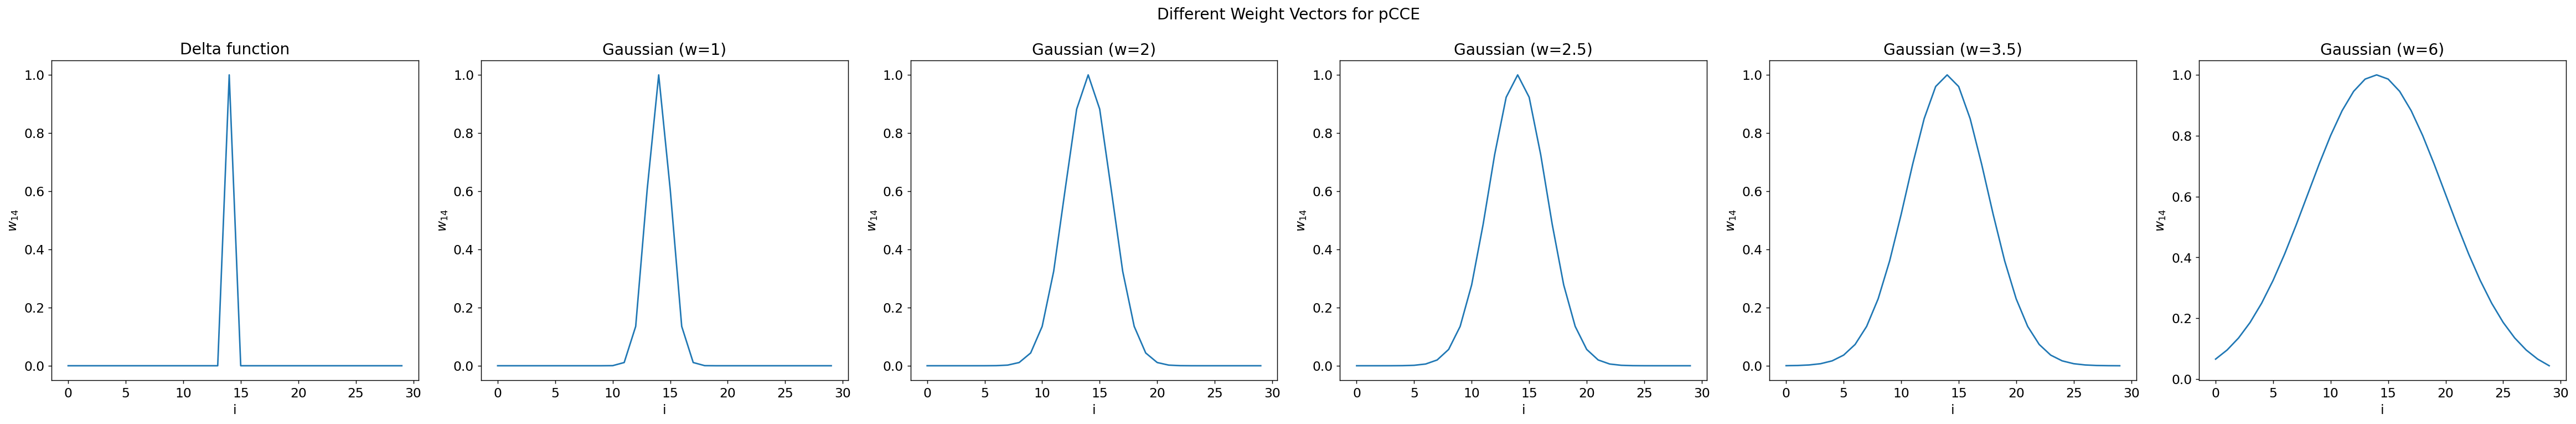

In [11]:
sampleLength = 30

weightVectors = [deltaWeight(sampleLength),
                   gaussianWeight(sampleLength, width=1),
                   gaussianWeight(sampleLength, width=2),
                   gaussianWeight(sampleLength, width=2.5),
                   gaussianWeight(sampleLength, width=3.5),
                   gaussianWeight(sampleLength, width=6)]

weightVectorNames = ['Delta function', 'Gaussian (w=1)',
                    'Gaussian (w=2)', 'Gaussian (w=2.5)',
                    'Gaussian (w=3.5)', 'Gaussian (w=6)']
weightVectorFileNames = ['delta', 'gauss1', 'gauss2', 'gauss25', 'gauss35', 'gauss6']

fig, ax = plt.subplots(1, len(weightVectors), figsize=(len(weightVectors)*6, 6))

selection = 14

for i in range(len(weightVectors)):
    ax[i].plot(weightVectors[i][selection])
    ax[i].set_xlabel('i')
    ax[i].set_title(weightVectorNames[i])
    ax[i].set_ylabel('$w_{'+str(selection)+'}$')

fig.suptitle('Different Weight Vectors for pCCE')
fig.tight_layout()
plt.savefig('pCCETest_images/weight_vectors.png')
plt.show()

In [12]:
def initializeNet(sampleLength, weightVector):
    model = keras.Sequential()

    # Add the input layer. None shape so that we can pass a variable length
    # array in
    model.add(layers.Input(shape=(1,sampleLength)))

    # Add two LSTM layers. No particular reason for 2, just seeing how it works
    # The return_sequences lets you chain together LSTM layers, otherwise it will
    # mess with the shape
    model.add(layers.LSTM(sampleLength, return_sequences=True, activation='relu'))
    #model.add(layers.LSTM(sample_length, return_sequences=True, activation='sigmoid'))
    #model.add(layers.LSTM(1, return_sequences=True, activation='softmax'))

    model.add(layers.Dense(sampleLength, activation='softmax'))
    
    def partial_pCCE(target, output):
        return pCCE(target, output, weightVector)
    
    model.compile(optimizer='adam', loss=partial_pCCE, metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.SGD(lr=.05), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

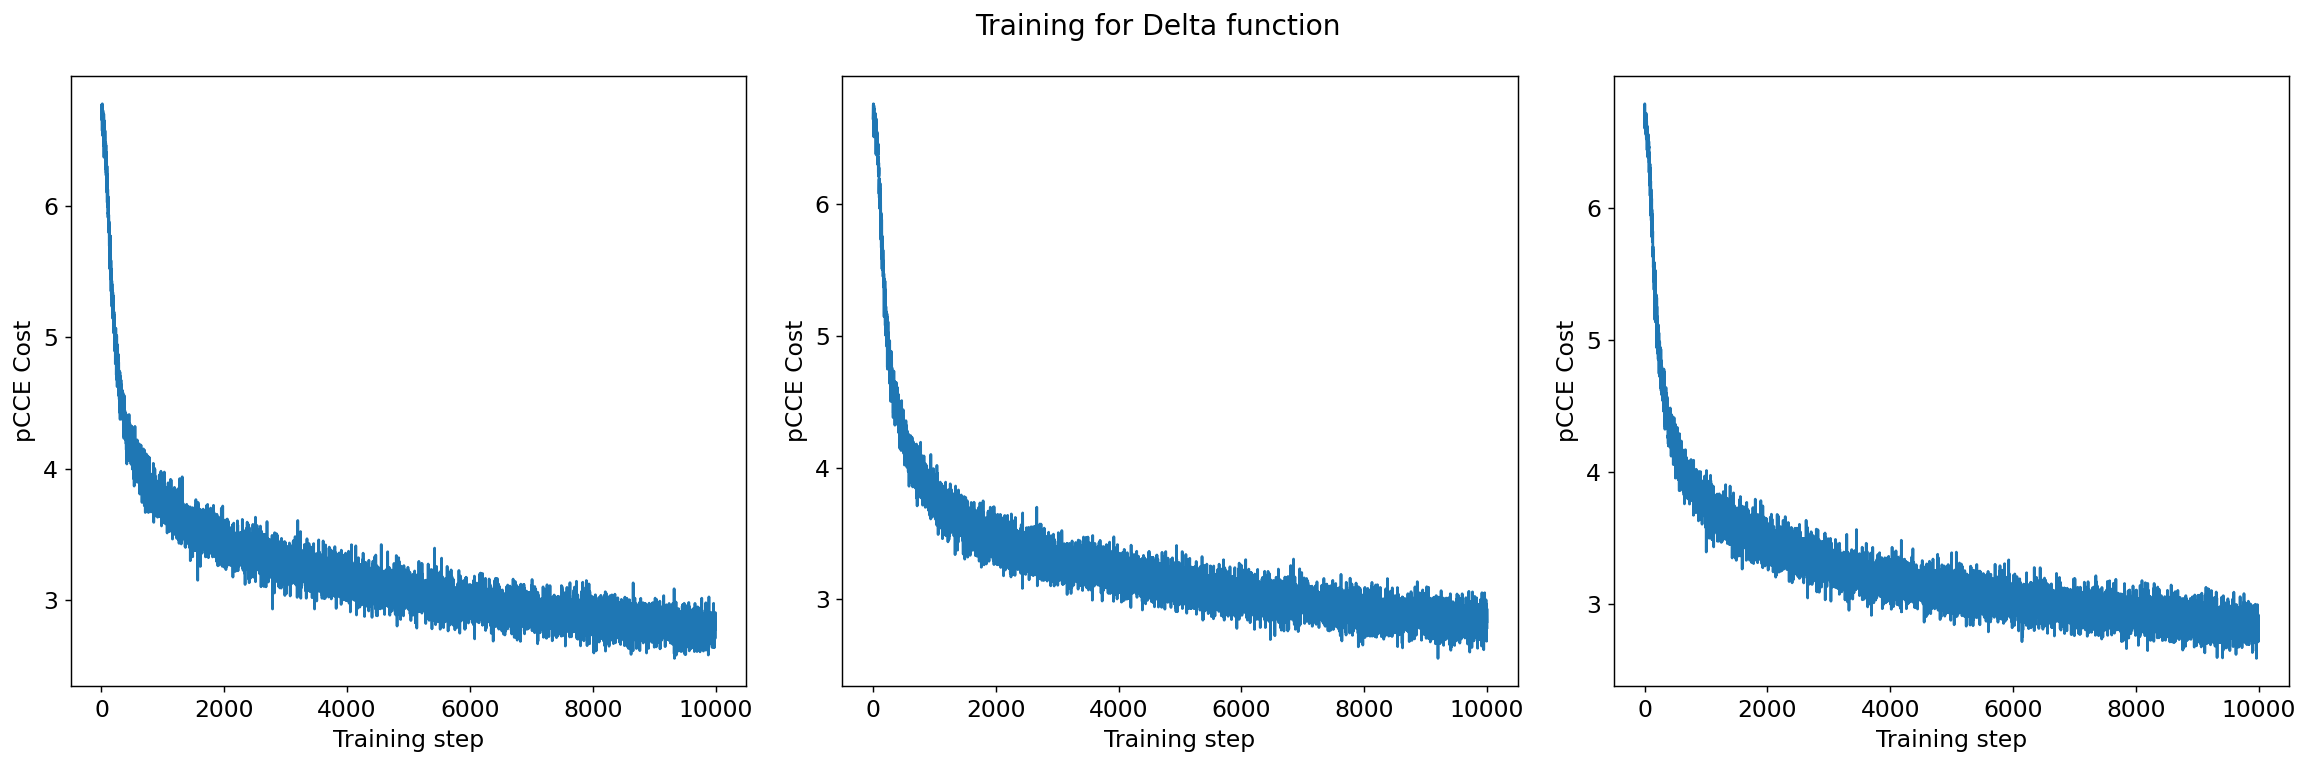

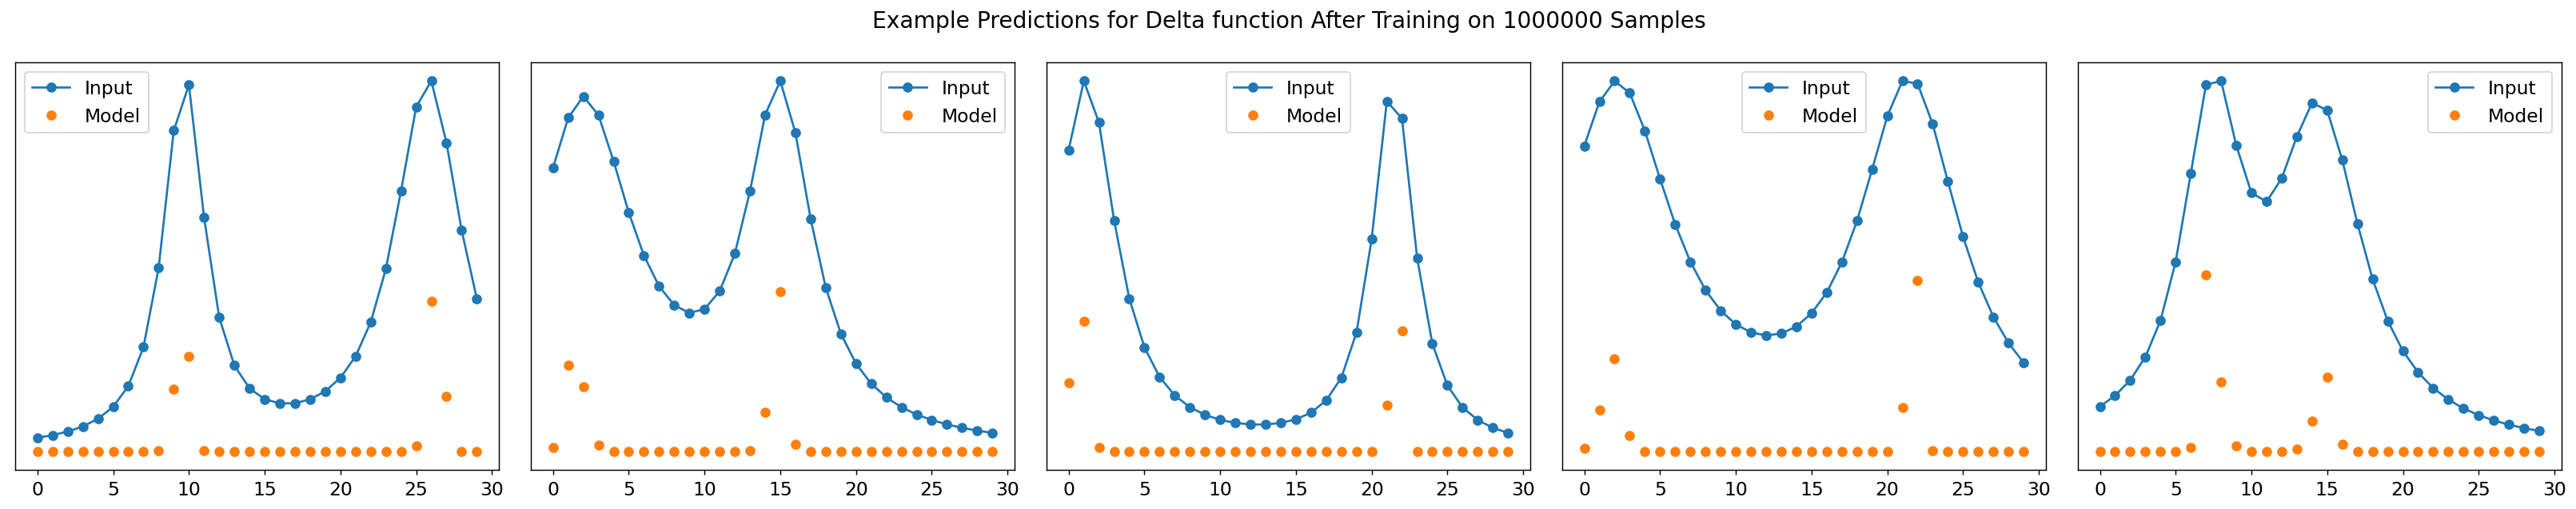

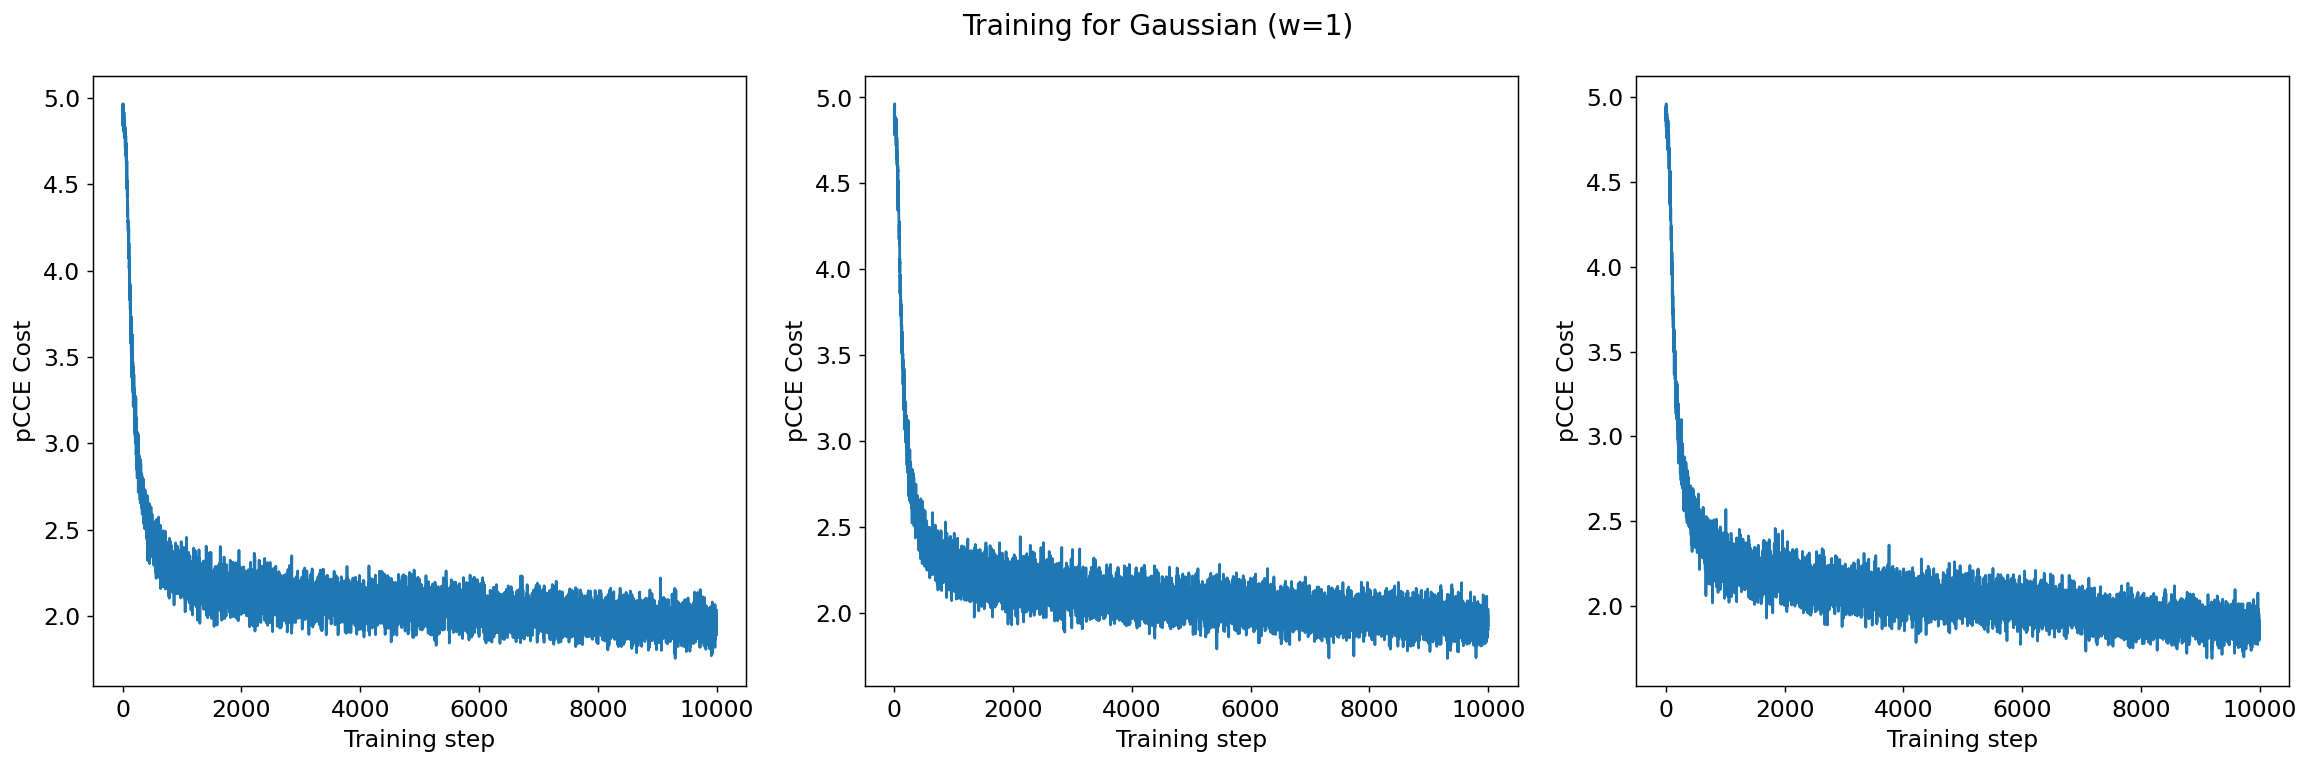

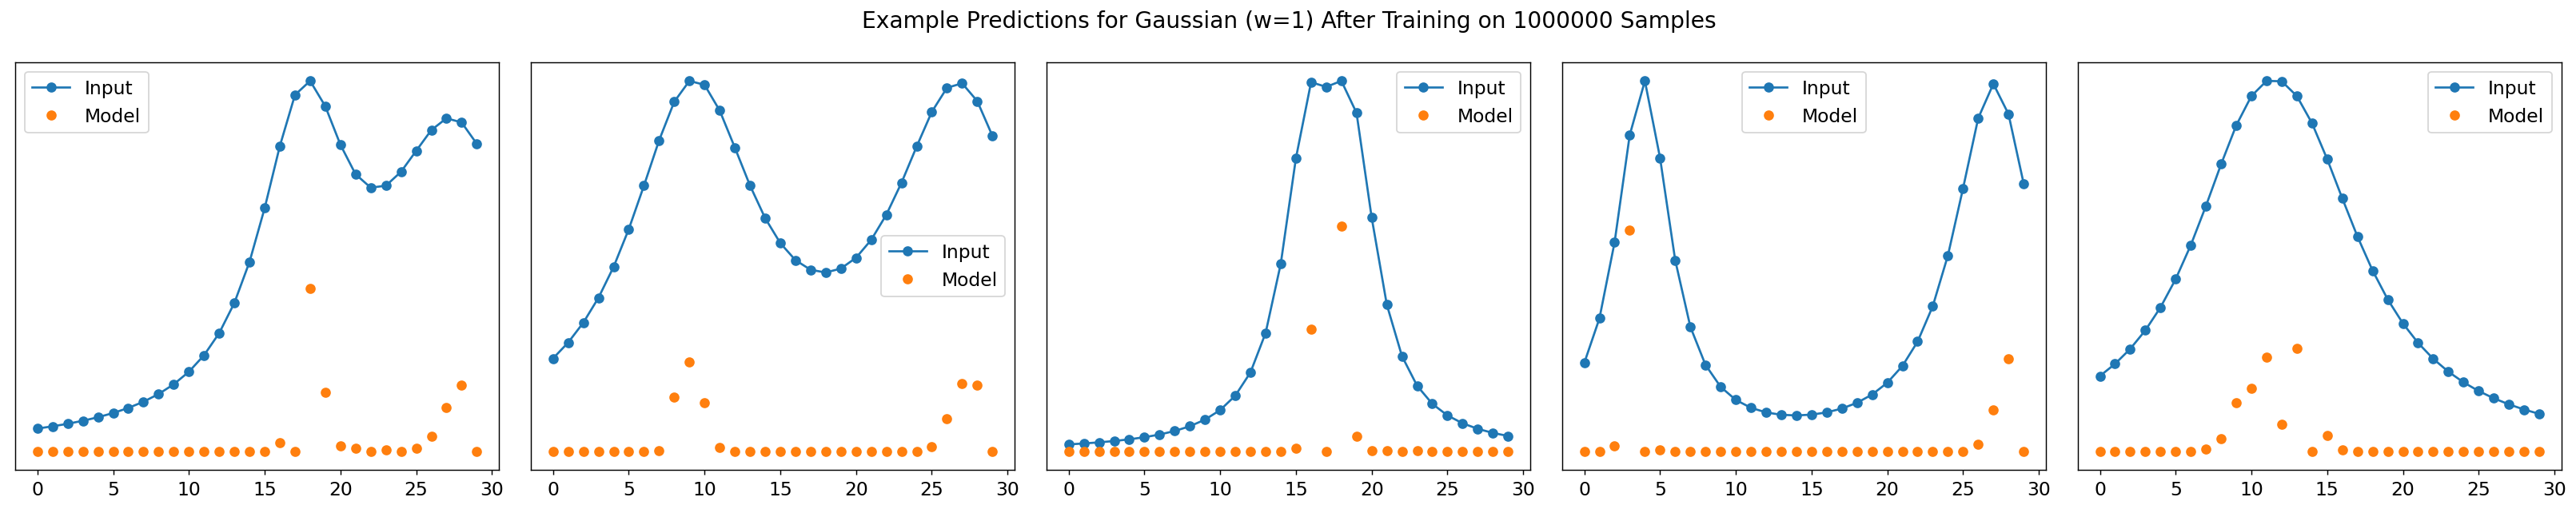

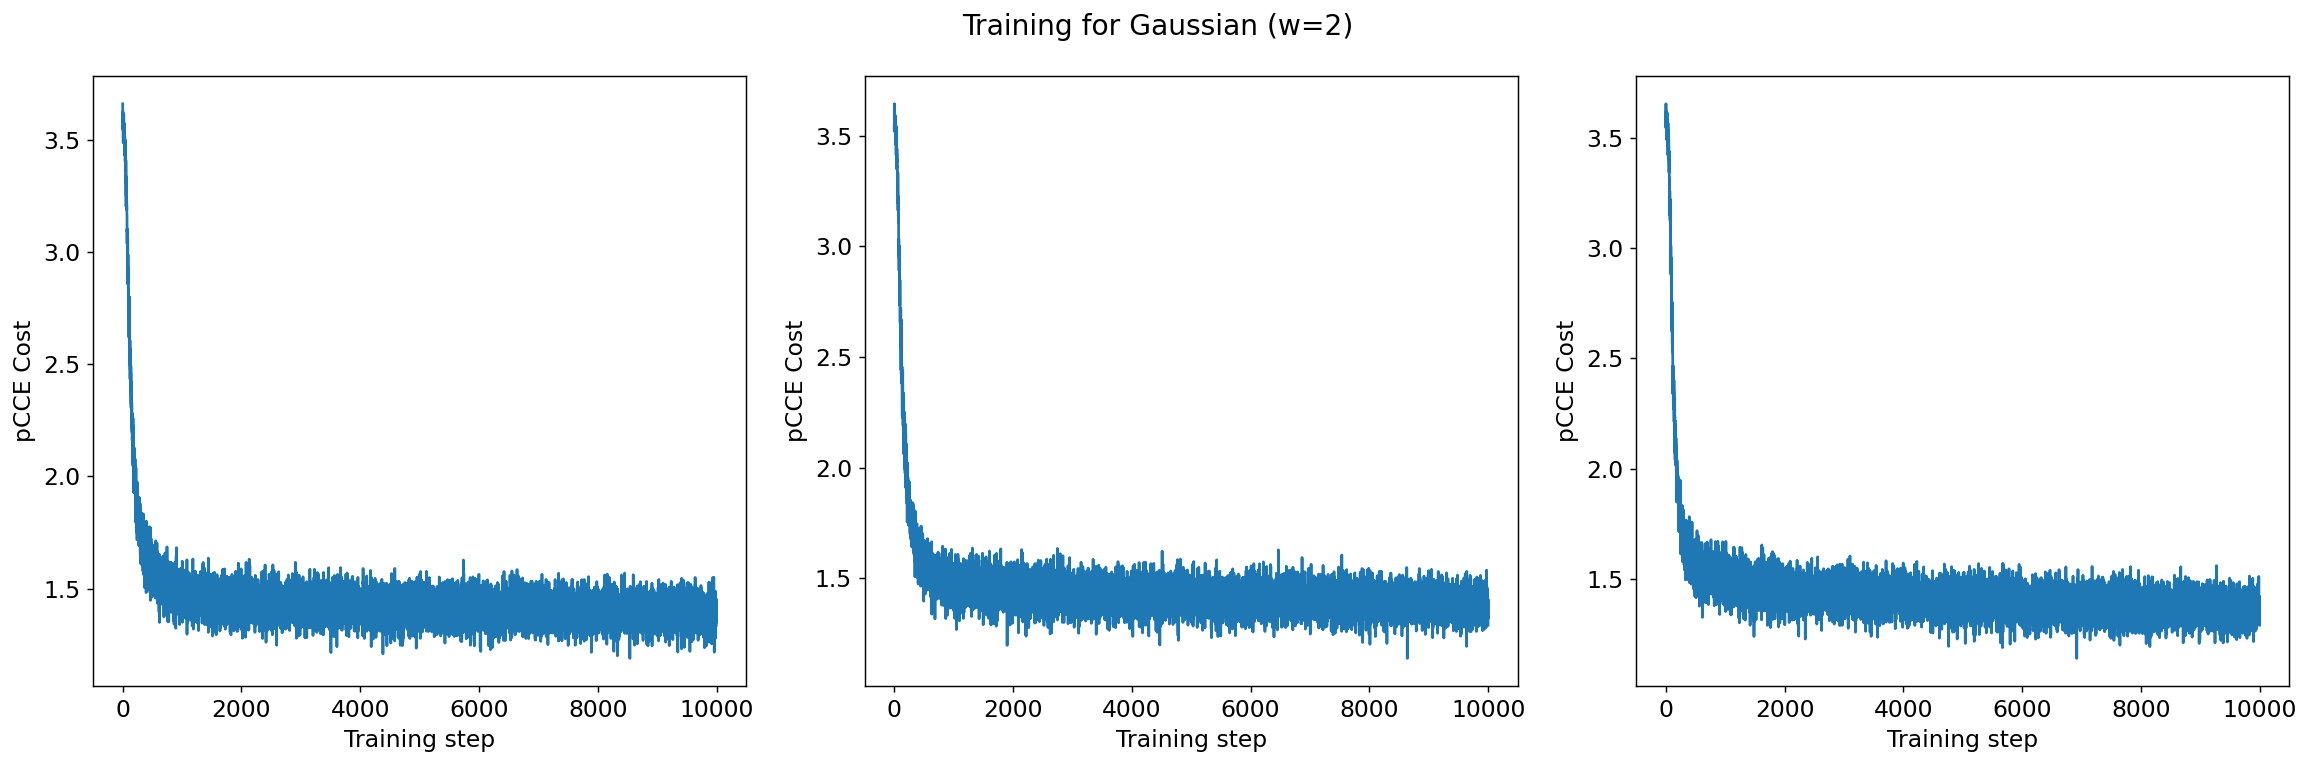

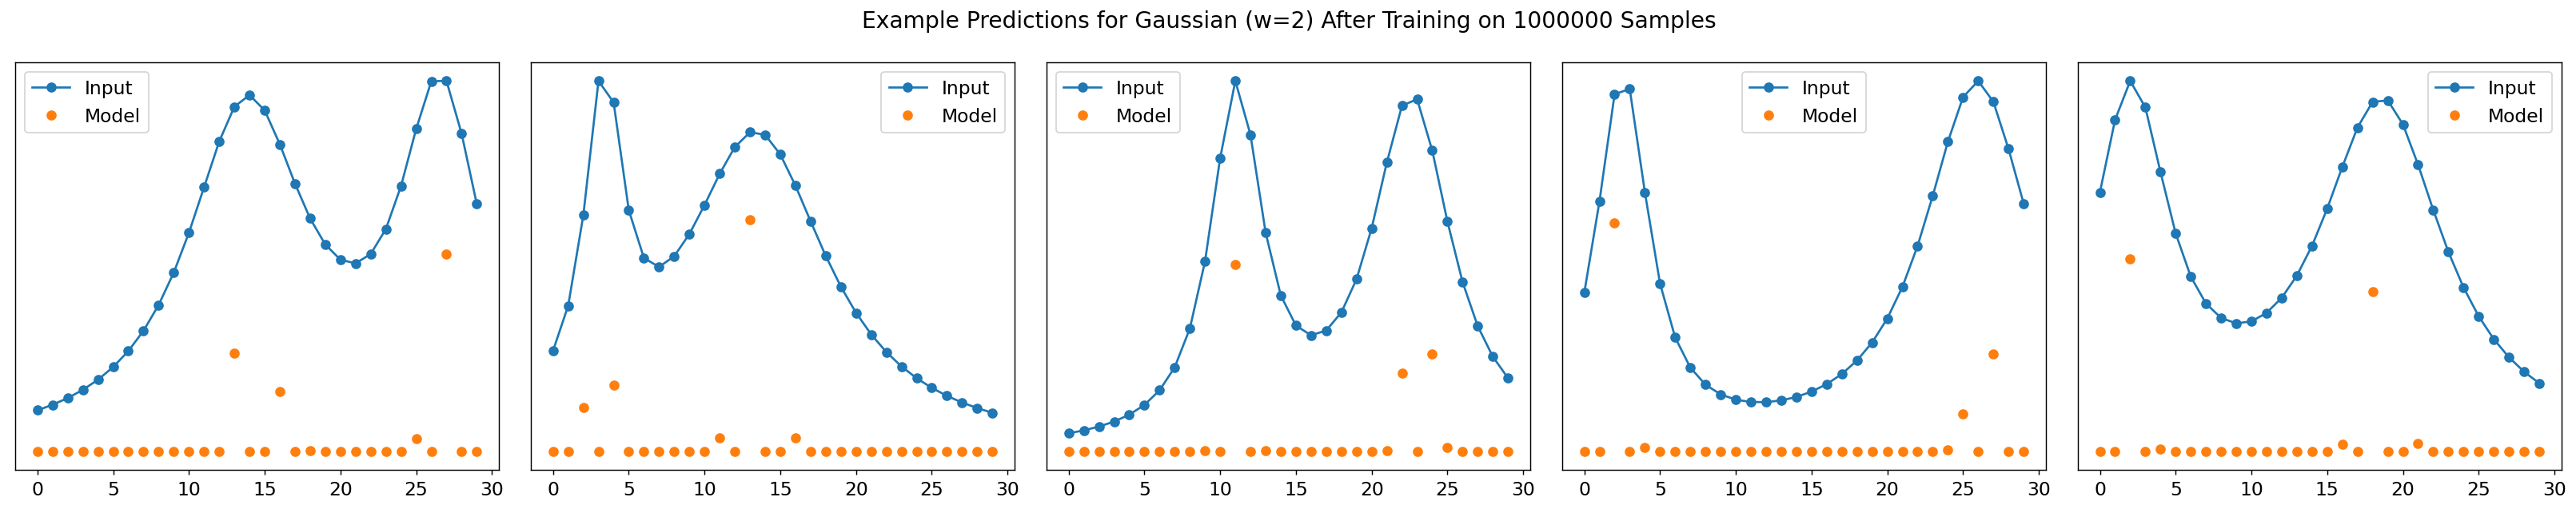

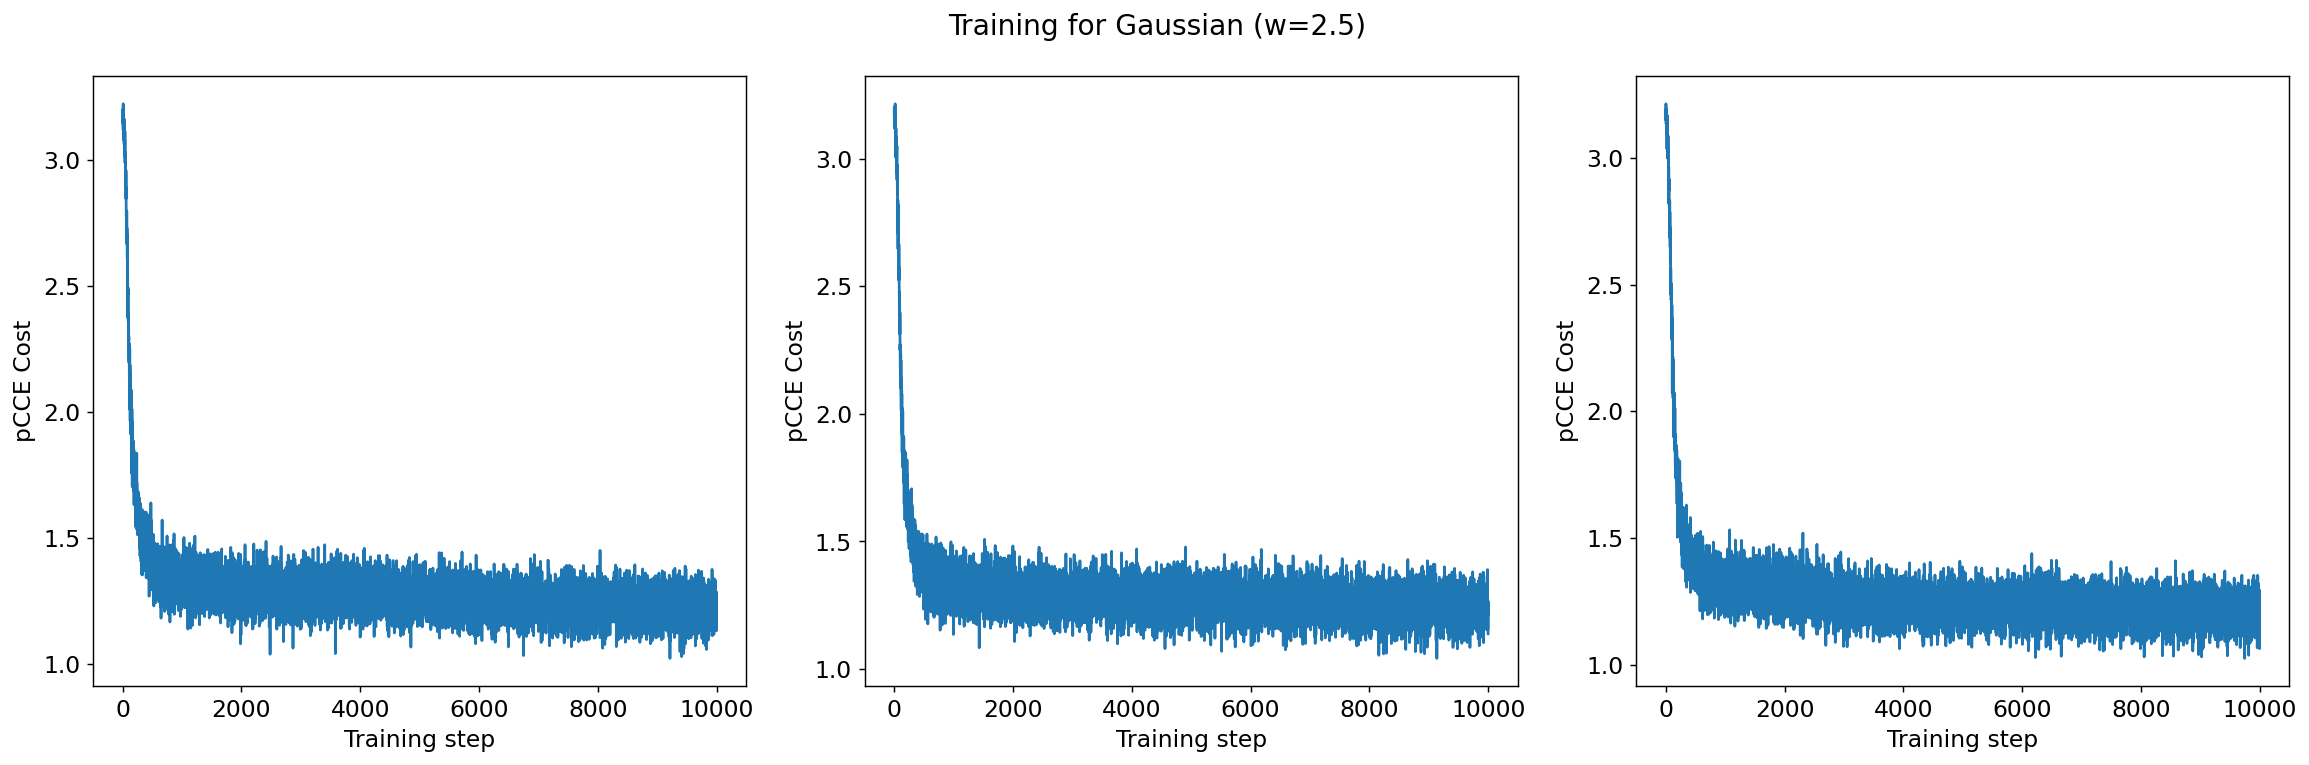

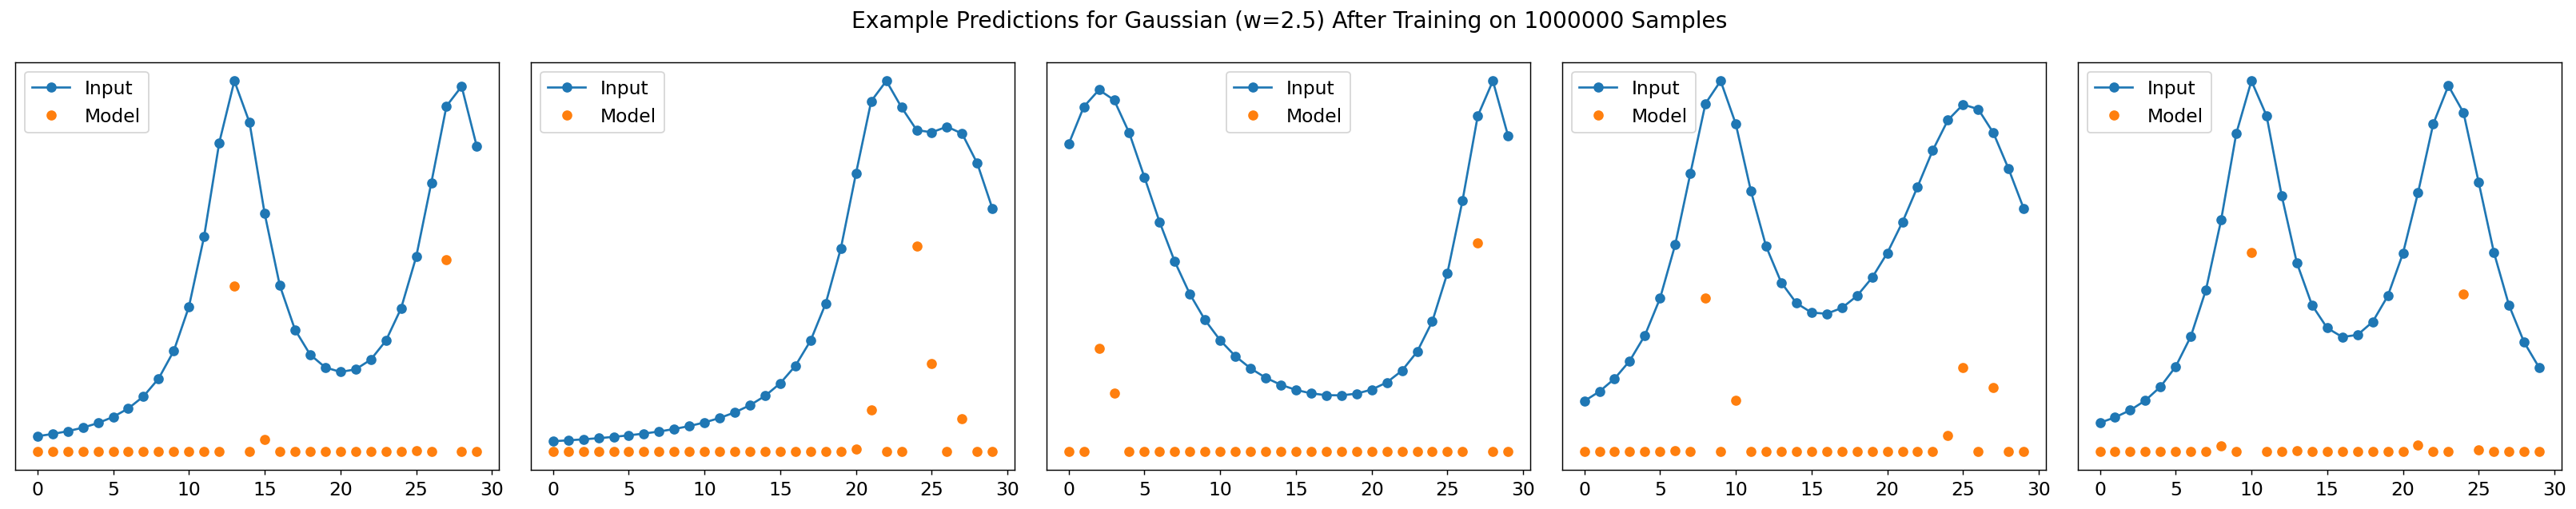

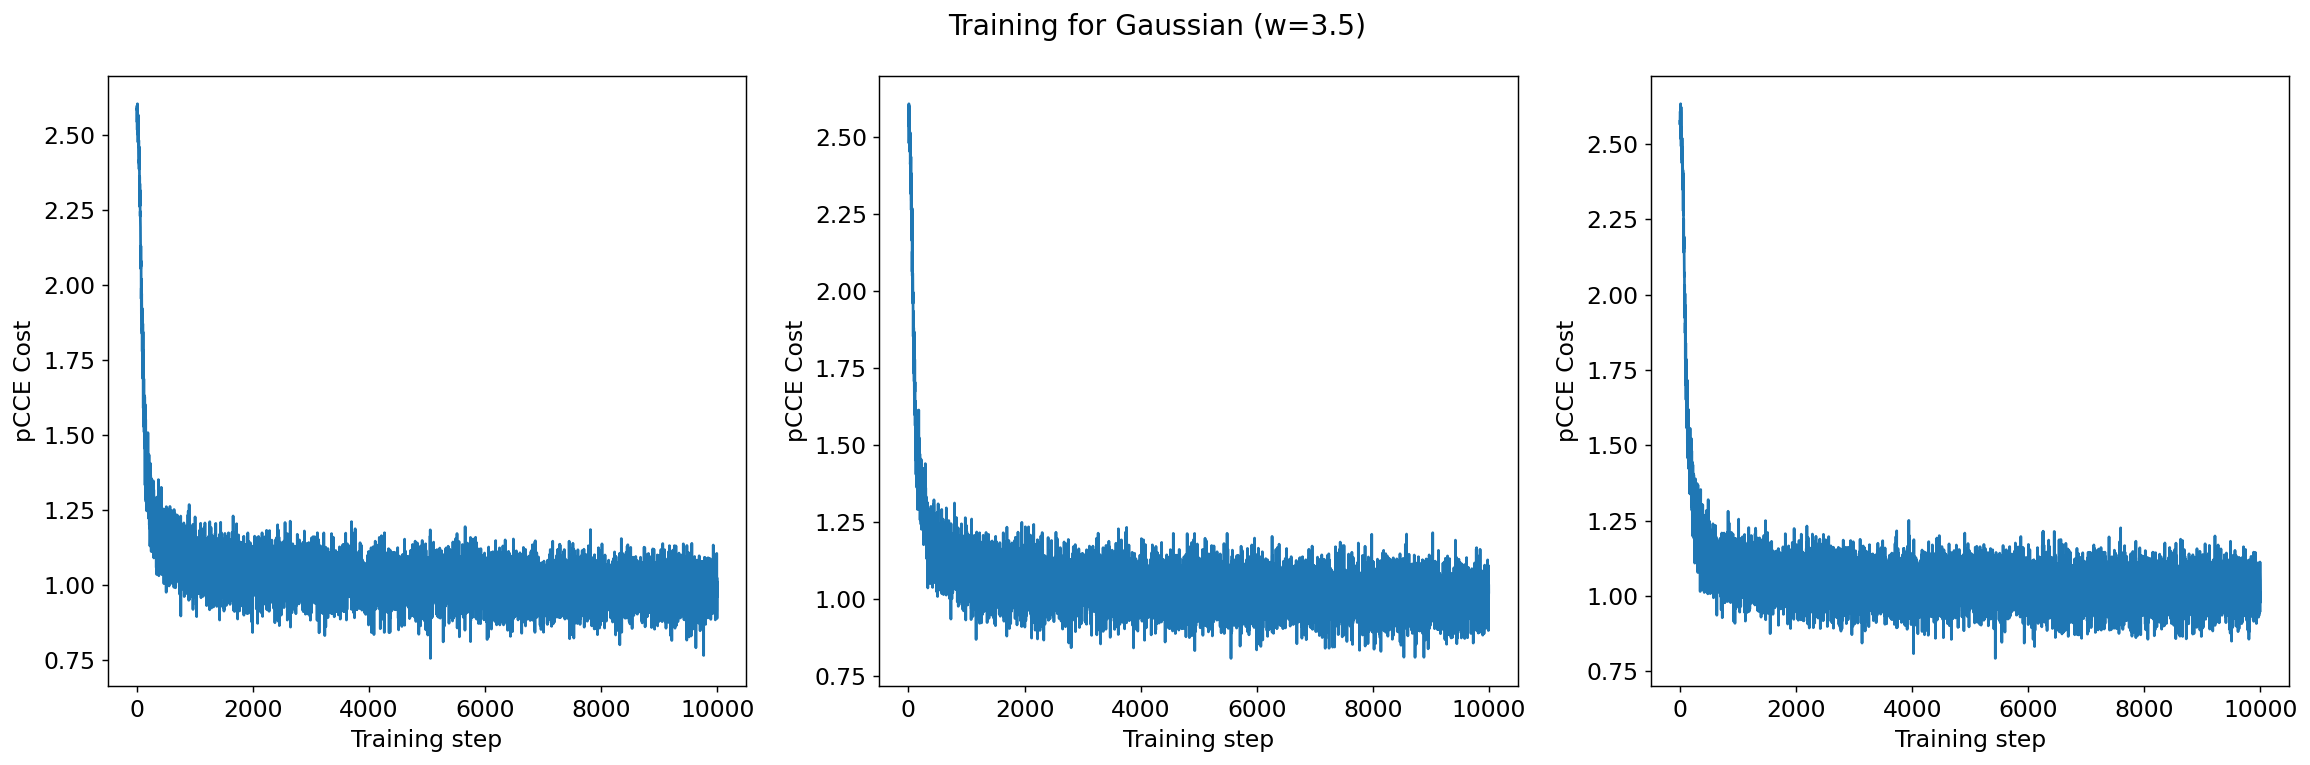

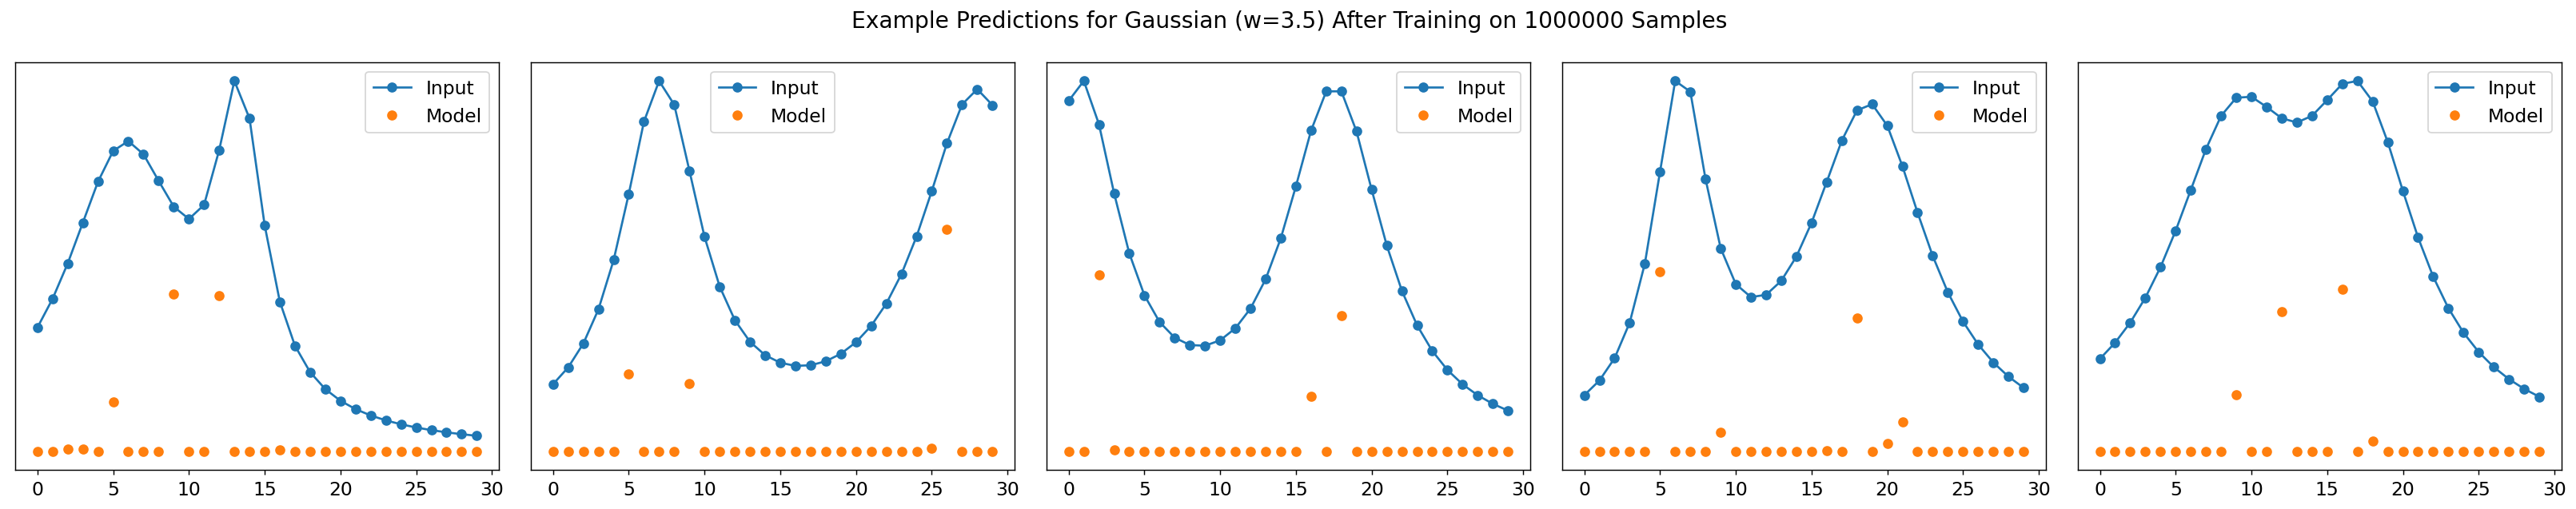

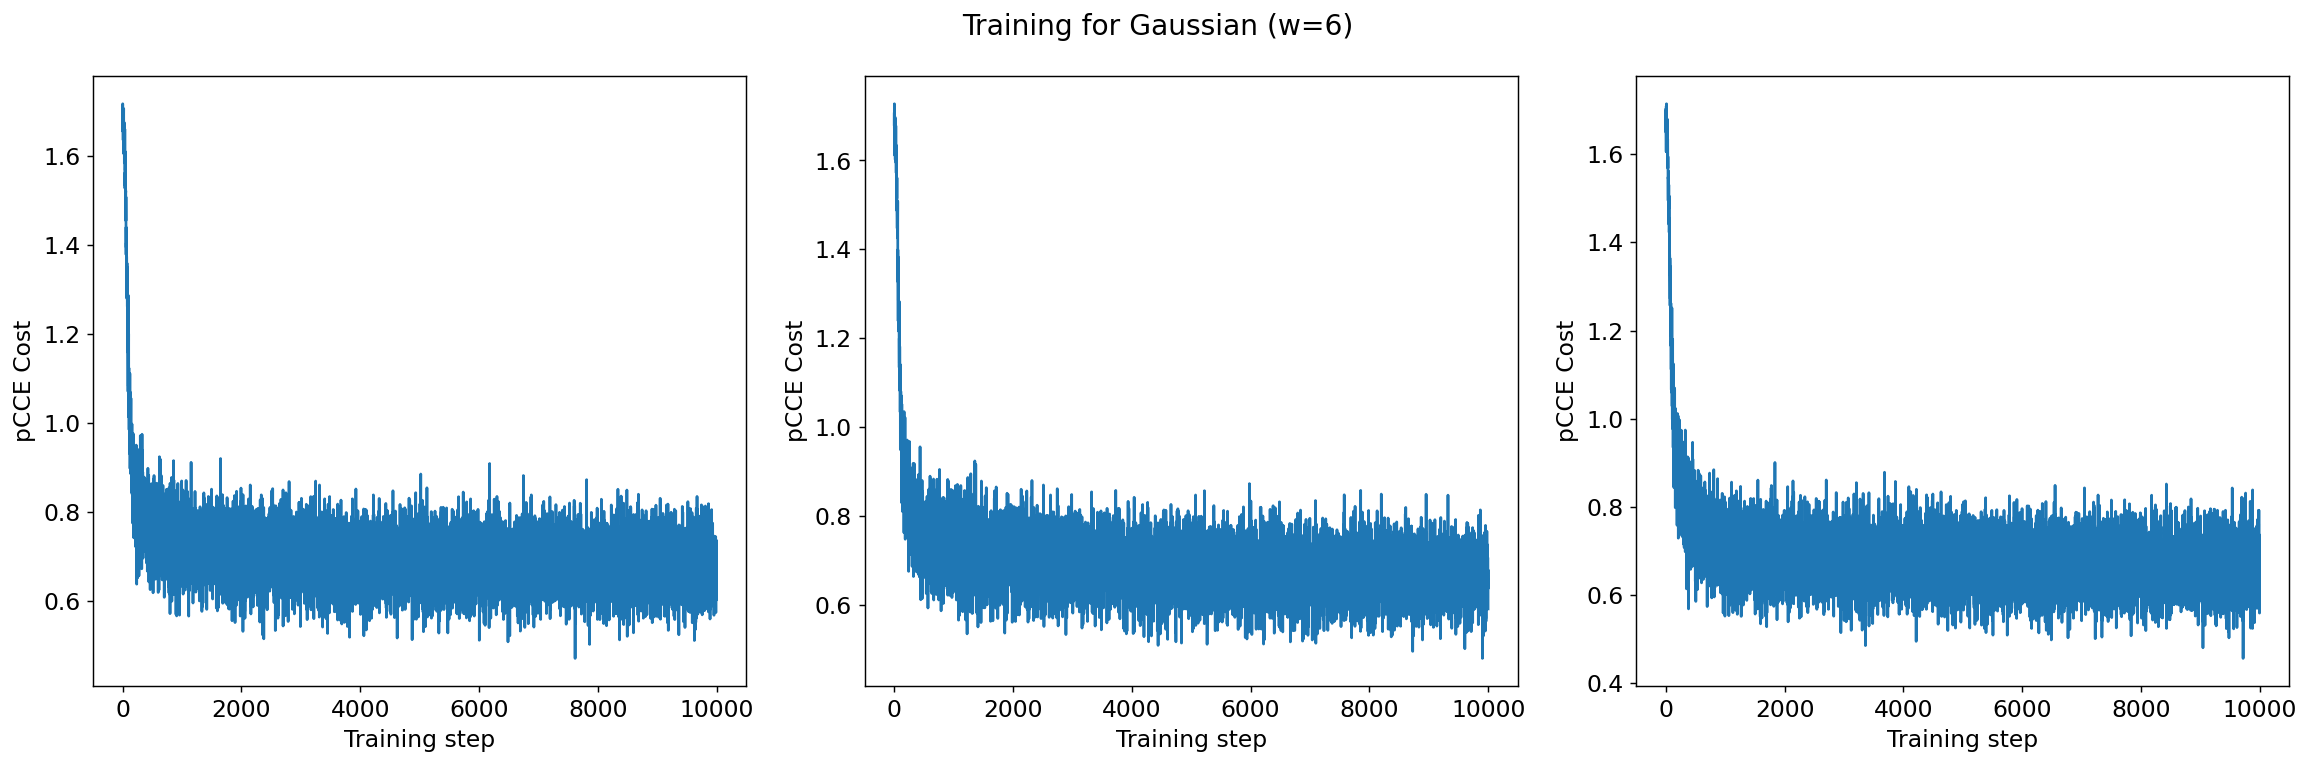

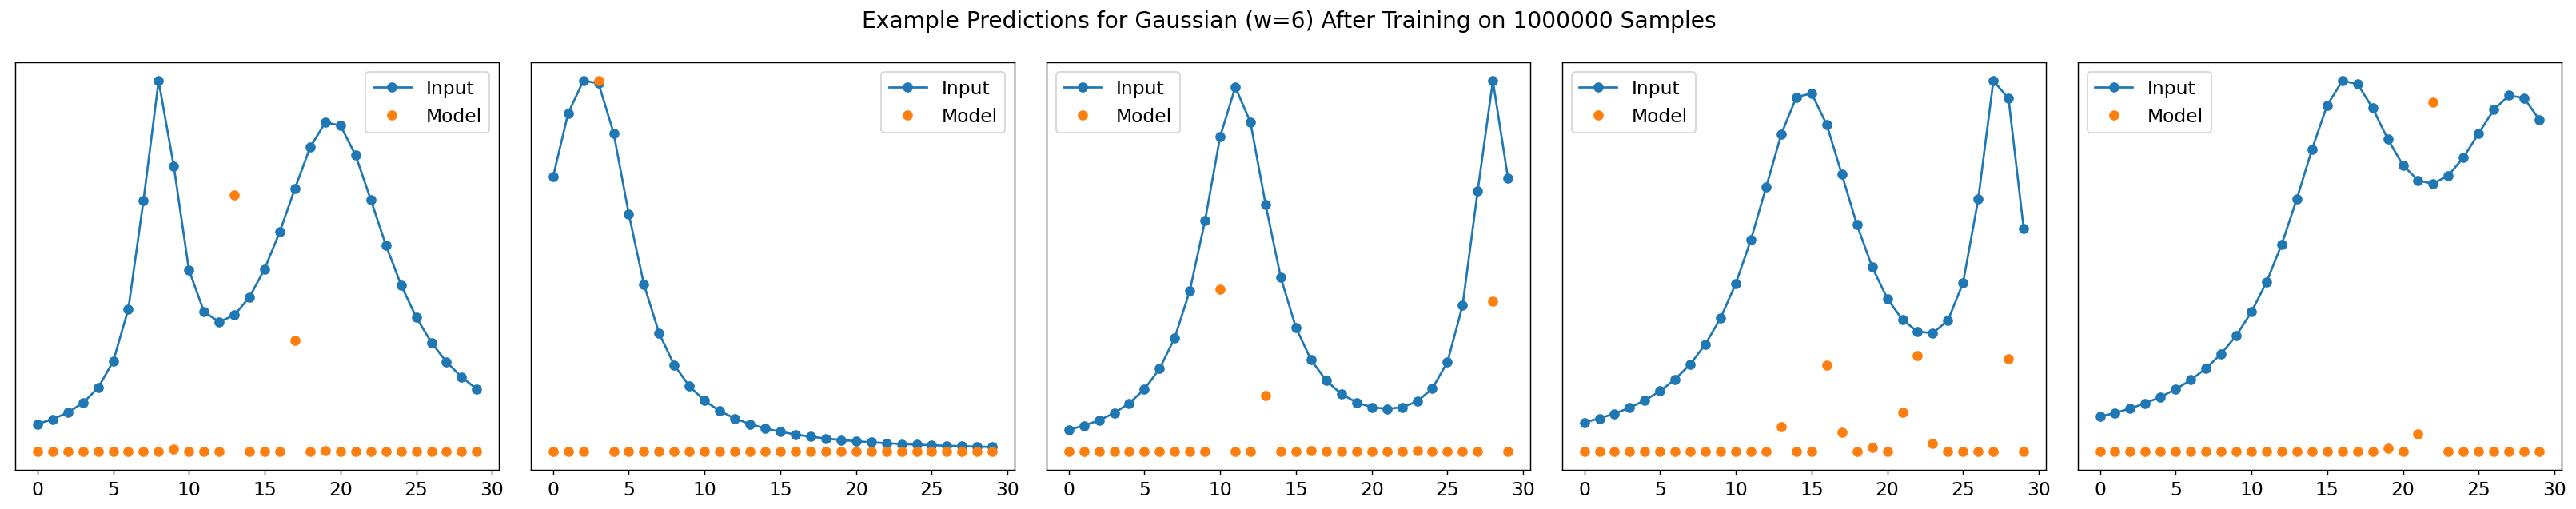

In [15]:
testsPerVector = 3
batchsize = 100
trainingSteps = 10000

for i in range(len(weightVectors)):
    #print(weightVectors[i+1])
    fig, ax = plt.subplots(1, testsPerVector, figsize=(testsPerVector*6, 6))
    error = np.zeros([testsPerVector, trainingSteps])

    for k in range(testsPerVector):
        
        model = initializeNet(sampleLength, weightVectors[i])
        
        if i == k and i == 0:
            keras.utils.plot_model(model, 'pCCETest_images/net_structure.png', show_shapes=True)
            

        for j in range(trainingSteps):
            inputs, outputs = generateBatchOneHot(batchsize, numPeaks=2)
            error[k,j] = model.train_on_batch(inputs, outputs)[0]

        ax[k].plot(error[k])
        ax[k].set_ylabel('pCCE Cost')
        ax[k].set_xlabel('Training step')

    fig.suptitle(f'Training for {weightVectorNames[i]}')
    fig.tight_layout()
    plt.savefig(f'pCCETest_images/{weightVectorFileNames[i]}_training.png')
    plt.show()
    
    # Now create samples for each
    inputs, outputs = generateBatchOneHot(5, numPeaks=2)
    #inputsT = tf.constant(inputs, shape=(5, 1, 30))

    predictions = model.predict_on_batch(inputs)
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))

    for j in range(5):
        ax[j].plot(inputs[j,0,:], 'o-', label='Input')
        ax[j].plot(predictions[j,0,:], 'o', label='Model')
        ax[j].set_yticks([])
        ax[j].legend()

    fig.suptitle(f'Example Predictions for {weightVectorNames[i]} After Training on {batchsize*trainingSteps} Samples')
    fig.tight_layout()
    plt.savefig(f'pCCETest_images/{weightVectorFileNames[i]}_results.png')
    plt.show()